
## Project:  Allstate Claims Severity
#### Author:   Joseph Downs, James Peng, Megan Pera, Diana Rodenberger 
#### Purpose:  Evaluate multiple regression models to predict cost and severity of claims for AllState
#### Created:  10/29/2016

### Team name in Kaggle: UCB_207_1

## Link to Leaderboard
https://www.kaggle.com/c/allstate-claims-severity/leaderboard


### Topics included

#### 1) Definition of global variables
#### 2) Preprocessing train set: create dummy variables, split dataset into train and dev
#### 3) Function to estimate best parameters for classifiers
#### 4) Data Exploration of Continous Variables
#### 5) Model 1: Linear Regression with dummy variables using RIDGE
#### 6) Model 2: PCA and Regression
#### 7) Model 3: Run regression models with Lasso
#### 8) Model 4: Run regression models with ElasticNet
#### 9) Model 5: Run regression models with DecisionTreeRegressor





In [1]:
%matplotlib inline
import unittest

# General libraries.
import re, os, sys
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
#from sklearn.feature_extraction import 
from sklearn import preprocessing

from sklearn.utils import shuffle

from sklearn.metrics import mean_absolute_error

from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from pandas.tools.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression

# regularization methos
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV

/Users/megan/anaconda/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/megan/anaconda/lib/python3.4/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Global variables

In [2]:
##GLOBAL VARIABLES

DUMMY_COLS=[]  #list of dummy variables
CONTINOUS_COLS=[]  #list of continous variables
#R_CLS          #Regression classifier defined in multiple sections of the code

## Preprocessing train set

 1) Extract data and load into dataframe
 
 2) Create dummy variables for categorical variables
 
 3) Transform the variable 'loss'
 
 4) Create training datasets and development datasets.

In [3]:

df_data = pd.read_csv('./data_in/train.csv')
df_data.shape

(188318, 132)

In [4]:
#split data frame into categorical variables, continous variables (including all 'contx' variables and 'loss') and ids


#separate categorical variables & continous variables.
cat_cols=[]
cont_cols=[]
for c in df_data.columns:
    if c.find('cat') >=0: # -1: substring not found, >=0, starting index
        cat_cols.append(c)
    elif c.find('cont')>=0:
        cont_cols.append(c)

df_cont_vars = df_data[cont_cols]
        
#convert categorical variables into dummy variables
df_dummy_vars=pd.get_dummies(df_data[cat_cols])

#set global vars for later use
DUMMY_COLS=df_dummy_vars.columns
CONTINOUS_COLS=cont_cols


#create dataset with predictors
X = pd.concat([df_dummy_vars, df_cont_vars], axis=1)
#create dataset with dependent variable
y = np.log10(df_data.loss)
#create additioanl dataset with claim ids
id = df_data.id


X_train, X_dev, y_train, y_dev, id_train, id_dev = train_test_split( X, y, id, test_size=0.33, random_state=1)

In [5]:
print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_dev shape: ',X_dev.shape)
print('y_dev shape: ',y_dev.shape)


X_train shape:  (126173, 1153)
y_train shape:  (126173,)
X_dev shape:  (62145, 1153)
y_dev shape:  (62145,)


In [6]:
X_train.head(2)

,cat1_A,cat1_B,cat2_A,cat2_B,cat3_A,cat3_B,cat4_A,cat4_B,cat5_A,cat5_B,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
18739,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.380560,0.608838,0.546949,0.45289,0.42289,0.55533,0.511698,0.557380,0.642600,0.221177
155434,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.568839,0.439206,0.407462,0.45883,0.46853,0.52221,0.441763,0.443374,0.324464,0.340194


### Data Exploration of Continous Variables

More work needs to be done in this section

1) Check the distribution.

2) Check for correlation.

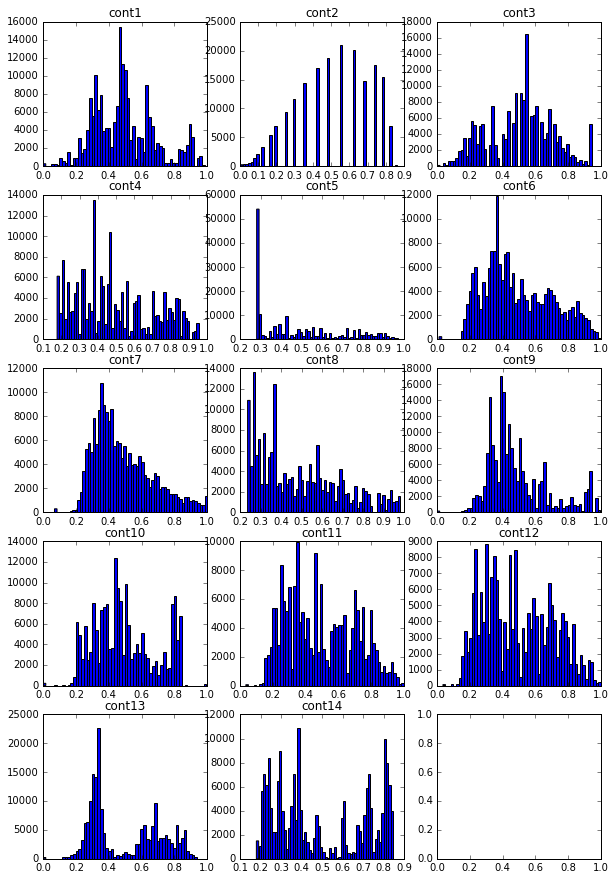

In [7]:
#function to plot histograms of continous variables
def PlotHisContinousVars(df):

    plt.subplots(5,3, figsize=(10,15))
    jj = 0
    for column_name in df.columns:
        jj+=1
        plt.subplot(5,3,jj).hist(df[column_name],normed=False, bins=60)
        plt.subplot(5,3,jj).set(title=column_name)
    plt.show()
 

PlotHisContinousVars(df_cont_vars)


Plot dependent variable

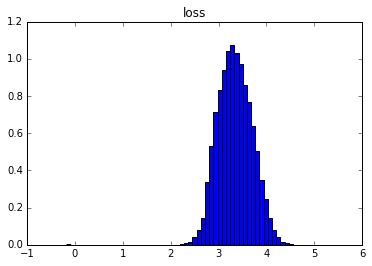

In [8]:
plt.cla()
plt.subplot(1,1,1).hist(y_train,normed=True, bins=60)
plt.subplot(1,1,1).set(title='loss')
plt.show()

Visualizing a scatter plot matrix for continuous variables to investigate autocorrelation.

/Users/megan/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


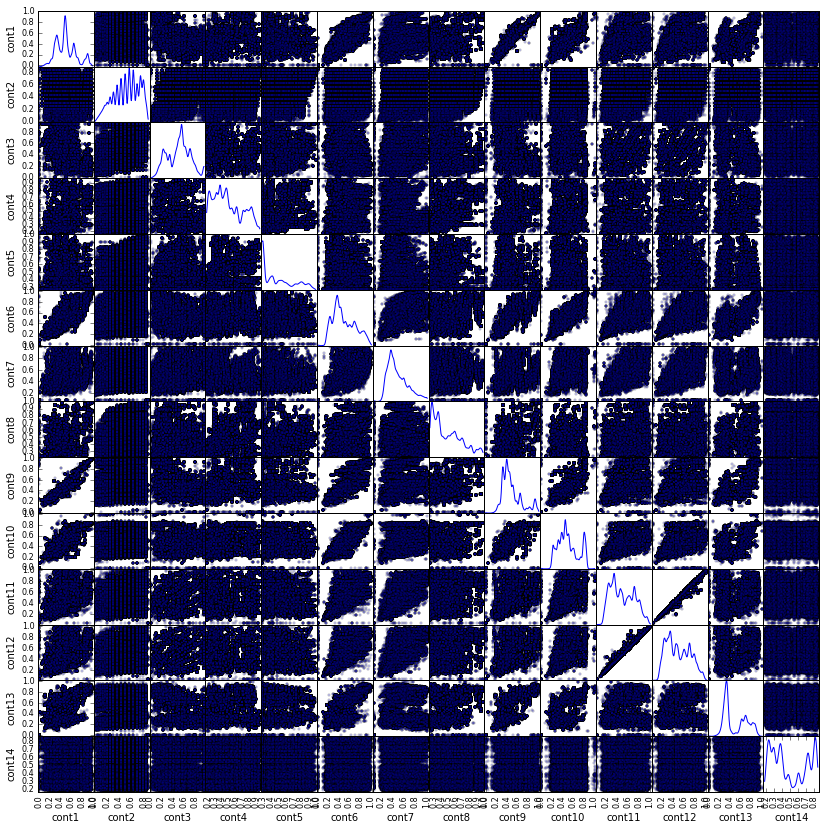

In [7]:
# Building the scatterplot matrix using the training data
scatter_matrix(df_cont_vars, alpha=0.2, figsize=(14, 14), diagonal='kde')
plt.show()

#### TODO: more data exploration of continous variables

### Function to estimate best parameters for classifiers

Warning: The call to this function can take a long time.

In [9]:
def EvaluateHyperParams(cls, params, X_data, y_data):
    
    pipeline = Pipeline([
     ('clf', cls),
    ])

    
    
    grid_search = GridSearchCV(pipeline, params)
    grid_search.fit(X_data, y_data)
    
    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters

### Baseline scores

The following are the baseline scores submitted for the competition

mean_absolute_error on training data: [-0.19872471 -0.19753498 -0.19821047]

mean_absolute_error on test data 0.198086964004104


#### Function to estimate MAE for specified regression classifier (Ridge, Lasso, etc)

In [26]:
def EstimateMAEForRegression(cls, X_train,y_train,X_test, y_test):
    
    # Train the model using the training sets
    cls.fit(X_train, y_train)

    # predict dev set
    preds = cls.predict(X_test)
   
    s = cross_val_score(cls, X_train, y_train, scoring='neg_mean_absolute_error')
    
    

    print('mean_absolute_error on training data: {0}'.format(s))

    mae = mean_absolute_error(y_test, preds)
    print('mean_absolute_error on dev data {0}'.format(mae))

### Model 1: Linear Regression with dummy variables using RIDGE

We will try 3 different values of alpha

TODO: Find optimal values of alpha combined with other hyper-parameters

Find optimal value of alpha

In [11]:
parameters = {
    'clf__alpha': (0.00001, .001, 0.1, 0.8),
    }
best_parameters=EvaluateHyperParams(cls=linear_model.Ridge(),params=parameters,X_data=X_train, y_data=y_train)

Best score: 0.515
Best parameters set:
	clf__alpha: 0.8


Somehow, GridSearch returns 0.8 as the best alpha value but in practice, the best parameter is 0.00001 of the ones that we tried.

#### alpha =0.00001

In [27]:
pd.options.mode.chained_assignment = None

alpha=0.00001

r_cls=linear_model.Ridge(alpha=alpha, normalize=True)

print("Regression -Ridge with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression -Ridge with alpha :  1e-05
mean_absolute_error on training data: [-0.19243734 -0.19133839 -0.19246453]
mean_absolute_error on dev data 0.19163931525070824


#### alpha =0.001

In [28]:
alpha=0.001

r_cls=linear_model.Ridge(alpha=alpha, normalize=True)

print("Regression -Ridge with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression -Ridge with alpha :  0.001
mean_absolute_error on training data: [-0.19241614 -0.19134146 -0.19247004]
mean_absolute_error on dev data 0.1916296757533237


#### alpha =0.1

In [29]:
alpha=0.1

r_cls=linear_model.Ridge(alpha=alpha, normalize=True)

print("Regression -Ridge with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression -Ridge with alpha :  0.1
mean_absolute_error on training data: [-0.19251016 -0.19139904 -0.1925847 ]
mean_absolute_error on dev data 0.19171244952642735


#### alpha=0.8 as suggested by GridSearchCV

In [30]:
alpha=0.8

r_cls=linear_model.Ridge(alpha=alpha, normalize=True)

print("Regression -Ridge with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression -Ridge with alpha :  0.8
mean_absolute_error on training data: [-0.19603084 -0.19491022 -0.19598921]
mean_absolute_error on dev data 0.19531763130822408


### Model 2: PCA and Regression

Create a model for regression that uses PCA components for dummy variables + continous variables. Here are the steps to run this model:

1) Create a dataset with PCA components of dummy variables. 

2) Create a dataset with just continous variables. 

3) Create a combined dataset using datasets from step 1 and 2.

4) Do steps 1-3 for training data and dev data.

5) Run regression.

### Pre-processing: Find the number of components that explains most of the variance.

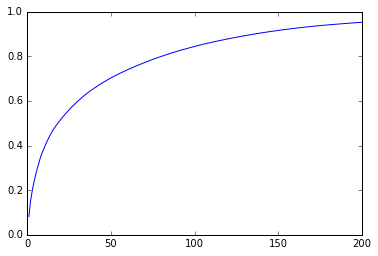

In [16]:


def ExploreNumPCAComponents(n_pca_comp):

    pca = PCA(n_components=n_pca_comp)
    pca.fit(X_train)
    cum_vars=[]
    components=[]
    cumulative_var=0
    for ii in range(len(pca.explained_variance_ratio_)):
        cumulative_var+=pca.explained_variance_ratio_[ii]
        cum_vars.append(cumulative_var)
        components.append(ii+1)
        
    plt.plot(components, cum_vars)
    
    plt.show()
    return cum_vars

cum_vars=ExploreNumPCAComponents(200)



In [17]:
print('Total variance explained by first PCA component: %0.6f \n' % cum_vars[0])
print('Total variance explained by 8 PCA components: %0.6f \n' % cum_vars[8])
print('Total variance explained by 50 PCA components: %0.6f \n' % cum_vars[49])
print('Total variance explained by 100 PCA components: %0.6f \n' % cum_vars[99])
print('Total variance explained by 200 PCA components: %0.6f \n' % cum_vars[199])

Total variance explained by first PCA component: 0.081600 

Total variance explained by 8 PCA components: 0.369046 

Total variance explained by 50 PCA components: 0.702629 

Total variance explained by 100 PCA components: 0.844001 

Total variance explained by 200 PCA components: 0.952089 



##### Total variance explained by 200 components is 95.21%. 

### Create Training set and Development Set with PCA components + Continous Variables

Function to create a dataframe with PCA components. 

In [18]:
def PCAComponentsToDataFrame(PCAComp, index_list):
    #### Purpose: Transform PCA components to DataFrame
    dic_comp={}
    ii=0
    for ii in range(PCAComp.shape[1]):
        key= 'comp' + str(ii+1)
        dic_comp[key]=PCAComp[:,ii]

    #create dataframes with pca components
    return pd.DataFrame(dic_comp, index=index_list)
    

##### Create a new training set and dev set with pca components (for dummy variables) +  continous variables

Try 200 components because that explains the most variance

In [19]:


n_pca_comp=200
    
#create with dummy variables to create PCA components - test
df_train_dummy_vars=X_train[DUMMY_COLS]
df_dev_dummy_vars=X_dev[DUMMY_COLS]

#create dataset with continous vars
df_dev_cont_vars=X_dev[CONTINOUS_COLS]
df_train_cont_vars=X_train[CONTINOUS_COLS]


#Run PCA with dummy vars
pca = PCA(n_components=n_pca_comp)
train_data_pca = pca.fit_transform(df_train_dummy_vars)
dev_data_pca = pca.transform(df_dev_dummy_vars)

#### Transform PCA components to DataFrame, preserve the index of the original datasets.
df_train_data_pca=PCAComponentsToDataFrame(train_data_pca,list(id_train.index))

df_dev_data_pca=PCAComponentsToDataFrame(dev_data_pca,list(id_dev.index))

#--- Concatenate PCA components and continous variables
X_train_pca = pd.concat([df_train_data_pca, df_train_cont_vars], axis=1)

X_dev_pca = pd.concat([df_dev_data_pca, df_dev_cont_vars], axis=1)

    


In [20]:
#checks

print(X_train.shape)
print(df_train_cont_vars.shape)
print(df_train_dummy_vars.shape)

print(df_train_data_pca.shape)
print(X_train_pca.shape)
print(X_dev_pca.shape)

(126173, 1153)
(126173, 14)
(126173, 1139)
(126173, 200)
(126173, 214)
(62145, 214)


### Run regression models with 200 PCA components + continous vars

In [21]:
parameters = {
    'clf__alpha': (0.00001, .001, 0.1, 0.8),
    'clf__solver': ('auto', 'sag'),
    }
best_parameters=EvaluateHyperParams(cls=linear_model.Ridge(),params=parameters,X_data=X_train_pca, y_data=y_train)

Best score: 0.510
Best parameters set:
	clf__alpha: 0.8
	clf__solver: 'sag'


In [31]:
alpha=0.00001

r_cls=linear_model.Ridge(alpha=alpha, normalize=True)

print("Regression with PCA components and continous variables -Ridge with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train_pca,y_train=y_train,X_test=X_dev_pca, y_test=y_dev)

Regression with PCA components and continous variables -Ridge with alpha :  1e-05
mean_absolute_error on training data: [-0.1932844  -0.19232054 -0.19277652]
mean_absolute_error on dev data 0.19257604362925101


In [32]:
alpha=0.1

r_cls=linear_model.Ridge(alpha=alpha, normalize=True)

print("Regression with PCA components and continous variables -Ridge with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train_pca,y_train=y_train,X_test=X_dev_pca, y_test=y_dev)

Regression with PCA components and continous variables -Ridge with alpha :  0.1
mean_absolute_error on training data: [-0.19484667 -0.19380686 -0.19426065]
mean_absolute_error on dev data 0.1941320703119683


In [33]:
alpha=0.0000001

r_cls=linear_model.Ridge(alpha=alpha, normalize=True)

print("Regression with PCA components and continous variables -Ridge with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train_pca,y_train=y_train,X_test=X_dev_pca, y_test=y_dev)

Regression with PCA components and continous variables -Ridge with alpha :  1e-07
mean_absolute_error on training data: [-0.19328436 -0.19232048 -0.19277651]
mean_absolute_error on dev data 0.19257599115765475


The following function features columns with the larges coefficients.

In [37]:
def SelectFeaturesLargestCoeff(cls, X):
    #select columns with top coe
    col_names=X.columns

    sorted_index=np.argsort(cls.coef_)
    best_coeff_vars=[]
    for ii in range(15):
        best_coeff_vars.append(col_names[sorted_index[(len(sorted_index)-ii-1)]])
    return best_coeff_vars
    



Use features with the largest coefficients

In [38]:
best_coeff_vars=[]
best_coeff_vars=SelectFeaturesLargestCoeff(r_cls,X_train_pca)
df_X_train_pca_best=X_train_pca[best_coeff_vars]
df_X_dev_pca_best=X_dev_pca[best_coeff_vars]

In [39]:
parameters = {
    'clf__alpha': (0.00001, .001, 0.1, 0.8),
     }
best_parameters=EvaluateHyperParams(cls=linear_model.Ridge(),params=parameters,X_data=df_X_train_pca_best, y_data=y_train)

Best score: 0.409
Best parameters set:
	clf__alpha: 0.8


In [40]:
alpha=0.8

r_cls=linear_model.Ridge(alpha=alpha, normalize=True)

print("Regression using features with largest coefficients (PCA comp + cont var) -Ridge with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=df_X_train_pca_best,y_train=y_train,X_test=df_X_dev_pca_best, y_test=y_dev)



Regression using features with largest coefficients (PCA comp + cont var) -Ridge with alpha :  0.8
mean_absolute_error on training data: [-0.23438716 -0.23314661 -0.23406143]
mean_absolute_error on dev data 0.23369849535881398


### Model 3: Run regression models with Lasso

In [41]:
parameters = {
    'clf__alpha': (0.00001, .001, 0.1, 0.8),
     }
best_parameters=EvaluateHyperParams(cls=linear_model.Lasso(),params=parameters,X_data=X_train_pca, y_data=y_train)

Best score: 0.510
Best parameters set:
	clf__alpha: 1e-05


In [42]:
alpha=0.00001

r_cls=linear_model.Lasso(alpha=alpha, normalize=True)

print("Regression using PCA comp + cont var -Lasso with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression using PCA comp + cont var -Lasso with alpha :  1e-05
mean_absolute_error on training data: [-0.19402205 -0.19310384 -0.19360335]
mean_absolute_error on dev data 0.19404828489146358


### Model 4: Run regression models with ElasticNet

In [44]:
alpha=0.1

r_cls=linear_model.ElasticNet(alpha=alpha, normalize=True)

print("Regression -ElasticNet with alpha : ", alpha)

EstimateMAEForRegression(cls=r_cls,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)

Regression -ElasticNet with alpha :  0.1
mean_absolute_error on training data: [-0.28671312 -0.28530872 -0.28741102]
mean_absolute_error on dev data 0.2870492180727514


### Model 5: Run regression models with DecisionTreeRegressor

In [50]:
max_depth=5

r_cls=DecisionTreeRegressor(max_depth=max_depth)

print("Regression -DecisionTreeRegressor with max_depth : ", max_depth)

EstimateMAEForRegression(cls=r_cls,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)


Regression -DecisionTreeRegressor with max_depth :  5
mean_absolute_error on training data: [-0.22122523 -0.22006794 -0.22022364]
mean_absolute_error on dev data 0.22001315494768253


In [52]:
max_depth=15

r_cls=DecisionTreeRegressor(max_depth=max_depth)

print("Regression -DecisionTreeRegressor with max_depth : ", max_depth)

EstimateMAEForRegression(cls=r_cls,X_train=X_train,y_train=y_train,X_test=X_dev, y_test=y_dev)


Regression -DecisionTreeRegressor with max_depth :  15
mean_absolute_error on training data: [-0.21463787 -0.21365397 -0.21327359]
mean_absolute_error on dev data 0.2088402841718654


### Predict the Test Dataset

 1) Extract data and load into dataframe
 
 2) Create dummy variables for categorical variables
 
 3) Predict loss based on 'best' model previously found : Ridge with alpha= 0.00001


In [ ]:
# = pd.read_csv('./data_in/test.csv')

In [ ]:
#test_cat_cols=[]
#test_cont_cols=[]
#for c in df_test.columns:
    #if c.find('cat') >=0: # -1: substring not found, >=0, starting index
        #test_cat_cols.append(c)
    #elif c.find('cont')>=0:
        #test_cont_cols.append(c)

#test_df_cont_vars = df_test[test_cont_cols]
        
#convert categorical variables into dummy variables
#test_df_dummy_vars=pd.get_dummies(df_test[test_cat_cols])

#create dataset with predictors
#X_test = pd.concat([test_df_dummy_vars, test_df_cont_vars], axis=1)
#id_test = df_test.id


In [ ]:

#print('num columns in test: ', X_test.shape[1])
#print('num columns in train: ', X_train.shape[1])

## Important note:

When transforming categorical variables into dummy variables, we get a different set of variables for the training data and the test data. The train data and the test data have different categories for some categorical variables; thus, when we tranform categorical variables to dummy variables then a different set of dummy variables for the train and test data. 

See file 'Allstate - Create train and test datasets with dummy vars' to fix this problem
